<a href="https://colab.research.google.com/github/Trapezun/skillfactory_rds/blob/master/project_module_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
from scipy.stats import ttest_ind
import numpy as np


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/skillfactory project 2/stud_math.xls')
pd.set_option('display.max_rows', 50) # показывать больше строк
pd.set_option('display.max_columns', 50) # показывать больше колонок

# Первичный осмотр данных

In [0]:
display(data.shape)

(395, 30)

Итого у нас 395 записей всего

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Имеем много колонок с числовыми данными и колонок с текстовыми данными. Почти все колонки имеют пустные значения. Надо будет их обработать перед анализом

Переименую колонку чтобы было удобнее

In [0]:
data = data.rename(columns={"studytime, granular": "granular"})

# Рассмотрим количество пустых значений

Узнаем для начала в процентном отношении сколько вообще пустых значений в каждой колонке

In [0]:
np.round(data.isna().sum()[data.isna().sum()>0] / data.shape[0], 2)

address       0.04
famsize       0.07
Pstatus       0.11
Medu          0.01
Fedu          0.06
Mjob          0.05
Fjob          0.09
reason        0.04
guardian      0.08
traveltime    0.07
studytime     0.02
failures      0.06
schoolsup     0.02
famsup        0.10
paid          0.10
activities    0.04
nursery       0.04
granular      0.02
higher        0.05
internet      0.09
romantic      0.08
famrel        0.07
freetime      0.03
goout         0.02
health        0.04
absences      0.03
score         0.02
dtype: float64

Для всех признаков сначала попробуем дропнуть строки с пропущенными значениями и посмотрим, сколько данных останется:


In [0]:
data.dropna().shape[0] / data.shape[0]

0.24556962025316456

Просто так удалить не получится. Надо обрабатывать каждую колонку по отдельности. 
Покажем пустые значение более наглядно

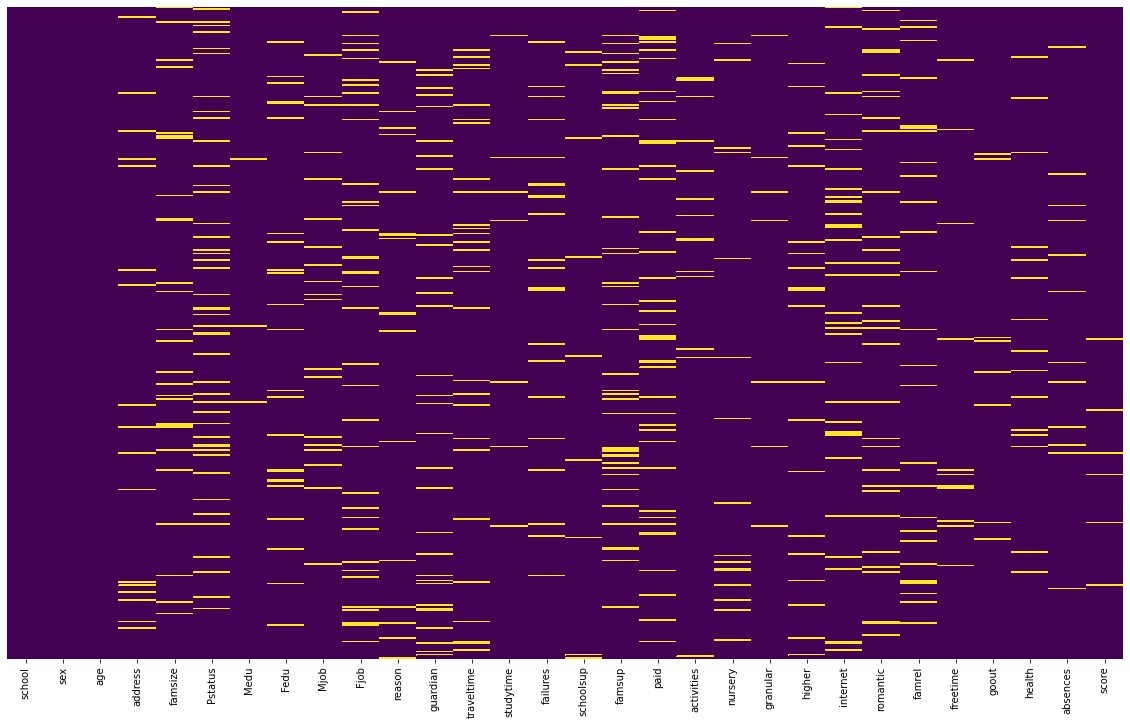

In [0]:
fig, ax = plt.subplots(figsize=(20,12))
sns_heatmap = sns.heatmap(data.isnull(), yticklabels=False, cbar=False, cmap='viridis')


Видим не очень приятную картину. Хотя пропусков не много, но они есть почти в каждой колонке. 

**Важный момент.**  В колонке score тоже есть пустый значения. Их надо удалить тк для нас эти записи безполезны


In [0]:
nul =  data[data.score.isnull()].index.tolist()
data = data.drop(nul)


# Удаляем ненужные числовые колонки


Перед тем как работать с численными колонками посмотрим на корреляцию с колонкой **score**. Может какие-то колонки можно вообще удалить и не тратить на них время

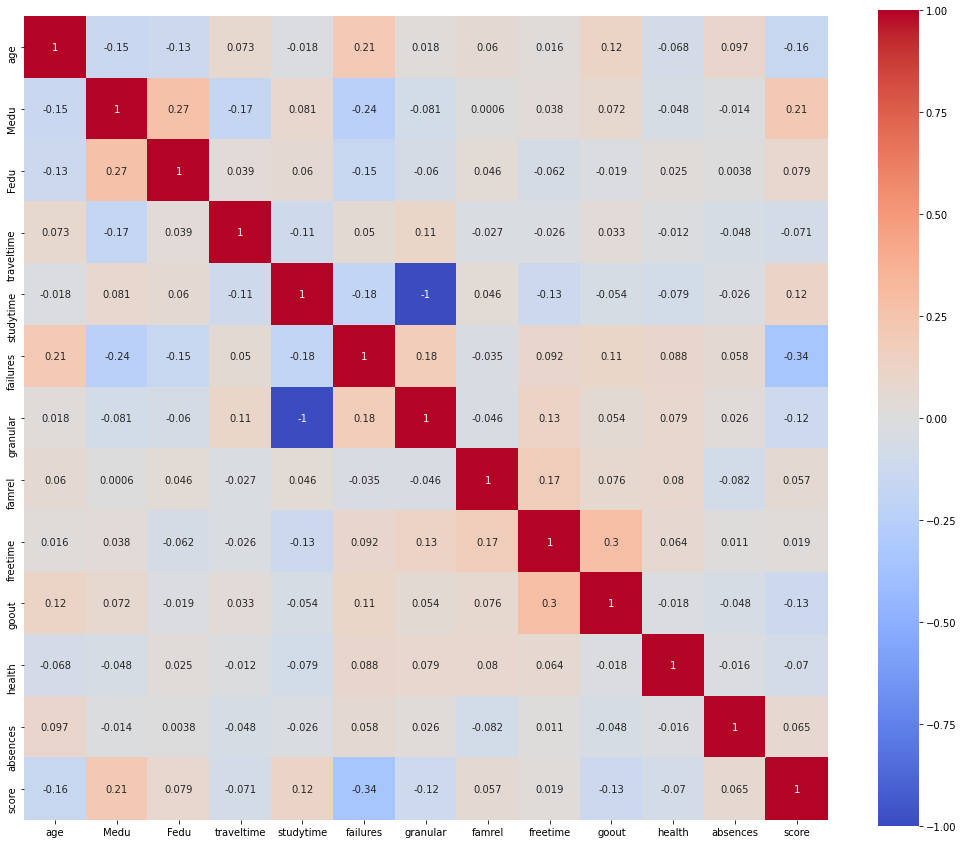

In [0]:
plt.subplots(figsize=(18,15))
sns.heatmap(data.corr(),annot=True, square=True, cmap=sns.color_palette("coolwarm", 10000), vmin=-1, center=0)
plt.show()

 Как видно, колонка **granular** и **studytime** полностью коррелированы. Удалю **granular**. Колонки **Fedu**, **traveltime**, **famrel**, **freetime**, **health**, **absences** вообще никак не влияют на **score**, их тоже можно удалить  
 

In [0]:
data = data.drop('granular', 1)
data = data.drop('traveltime', 1)
data = data.drop('famrel', 1)
data = data.drop('freetime', 1)
data = data.drop('health', 1)
data = data.drop('absences', 1)
data = data.drop('Fedu', 1)



Смотрим, что получилось


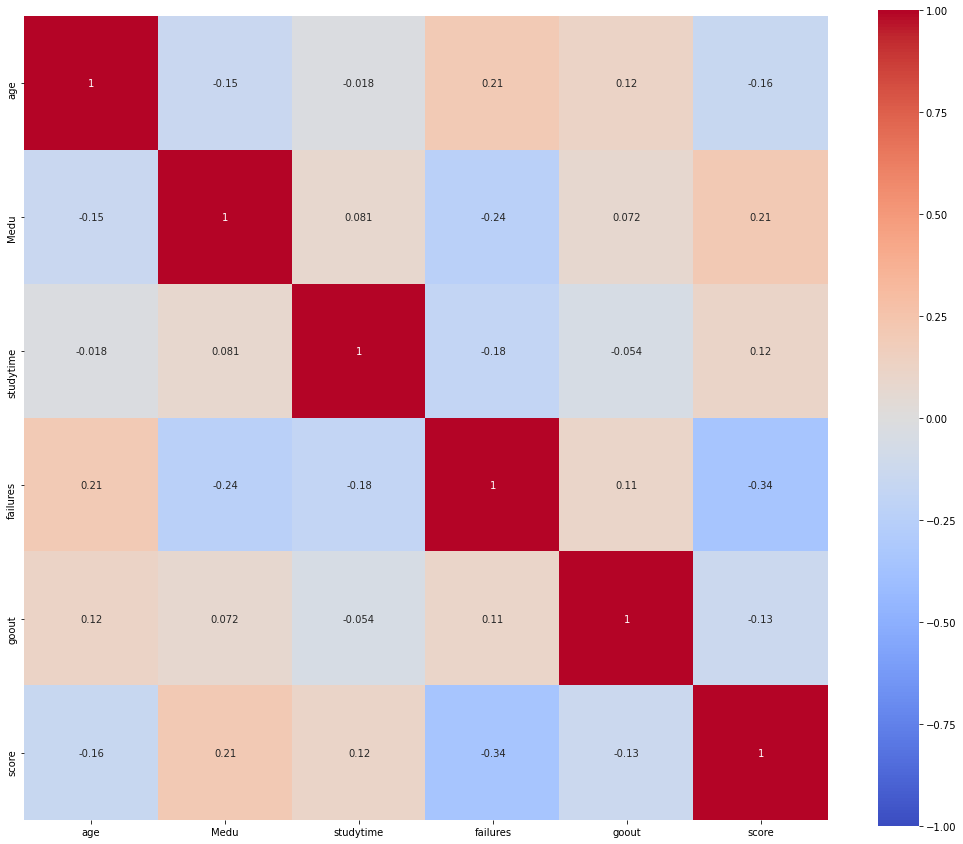

In [0]:
plt.subplots(figsize=(18,15))
sns.heatmap(data.corr(),annot=True, square=True, cmap=sns.color_palette("coolwarm", 10000), vmin=-1, center=0)
plt.show()

# Заполняем пустые числовые значения

Сделаю функцию, которая будет заполнять пустые значения разными данными. И будем считать как поменялась корреляция. В зависимости от этого поставим значения

In [0]:
def testfill(column):
  list_to_check = [0, data[column].min(), data[column].max(), data[column].mean(), data[column].median(),\
                    data[column].quantile(0.3), data[column].quantile(0.4), data[column].quantile(0.6),\
                    data[column].quantile(0.7)]                    
  list_of_names = ['0', 'min', 'max', 'mean', 'median', 'quantile 0.3', 'quantile 0.4', 'quantile 0.6', 'quantile 0.7']
  list_of_methods = ['bfill', 'ffill']
  
  print('Base for {}: {}'.format(column, data[column].corr(data.score)))
  for index, el in enumerate(list_to_check):    
    print('method: {}, correlation value: {:.4f}'.format(list_of_names[index], \
                                                    data[column].fillna(el).corr(data.score)))
  for el in list_of_methods:
    print('method: {}, correlation value: {:.4f}'.format(el, \
                                                     data[column].fillna(method=el).corr(data.score)))
  print('--------------') 


  

In [0]:
lst=['Medu','studytime','failures','goout']
for item in lst:
   testfill(item)   




Base for Medu: 0.21334872375060193
method: 0, correlation value: 0.2280
method: min, correlation value: 0.2280
method: max, correlation value: 0.2009
method: mean, correlation value: 0.2116
method: median, correlation value: 0.2098
method: quantile 0.3, correlation value: 0.2173
method: quantile 0.4, correlation value: 0.2173
method: quantile 0.6, correlation value: 0.2098
method: quantile 0.7, correlation value: 0.2009
method: bfill, correlation value: 0.2016
method: ffill, correlation value: 0.2122
--------------
Base for studytime: 0.11574134847030247
method: 0, correlation value: 0.0822
method: min, correlation value: 0.0990
method: max, correlation value: 0.1358
method: mean, correlation value: 0.1148
method: median, correlation value: 0.1143
method: quantile 0.3, correlation value: 0.1143
method: quantile 0.4, correlation value: 0.1143
method: quantile 0.6, correlation value: 0.1143
method: quantile 0.7, correlation value: 0.1143
method: bfill, correlation value: 0.1188
method: f

Итого:


*   Medu - ставим 0
*   studytime - ставим max
*   failures - ставим 0
*   goout - ставим ffill

In [0]:
data.Medu.fillna(0, inplace=True)
data.failures.fillna(0, inplace=True)
data.studytime.fillna(data.studytime.max(), inplace=True)
data.studytime.fillna(data.studytime.max(), inplace=True)
data.goout.fillna(data.goout.fillna(method='ffill'), inplace=True)

# Рассмотрим разброс числовых значений

In [0]:
def bar(column):  
  plt.figure(figsize=(5,2))
  sns.boxplot(data[column])

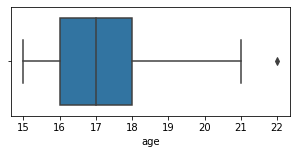

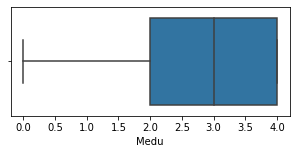

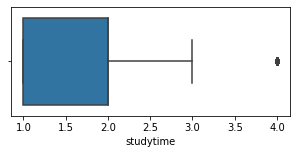

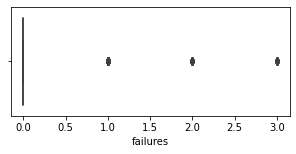

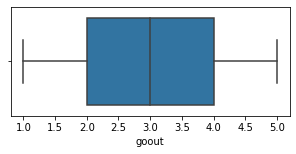

In [0]:
lst=['age','Medu','studytime','failures','goout']
for item in lst:
   bar(item)   

В числовых данных выбросов нет. 

# Заполняем пустые номинативные значения

In [0]:
colsnum = data.select_dtypes(include='object').columns.tolist()

In [0]:
data.select_dtypes(include='object').describe()

,school,sex,address,famsize,Pstatus,Mjob,Fjob,reason,guardian,schoolsup,famsup,paid,activities,nursery,higher,internet,romantic
count,389,389,374,362,344,370,353,372,358,380,351,350,375,374,369,355,358
unique,2,2,2,2,2,5,5,4,3,2,2,2,2,2,2,2,2
top,GP,F,U,GT3,T,other,other,course,mother,no,yes,no,yes,yes,yes,yes,no
freq,344,204,291,255,308,127,194,135,248,331,216,197,192,297,350,300,235


Судя по данным в них нет не стандартных значений. Поэтмому просто заменим все пустоты на слово None


In [0]:
for col in colsnum:
  data[col] = data[col].astype(str).apply(lambda x: None if pd.isnull(x) else x)

In [0]:
def get_boxplot(column):
    fig, ax = plt.subplots(figsize = (14, 4))
    sns.boxplot(x=column, y='score', 
                data=data.loc[data.loc[:, column].isin(data.loc[:, column].value_counts().index)],
               ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

def get_stat_dif(column):
    cols = data.loc[:, column].value_counts().index    
    combinations_all = list(combinations(cols, 2))
    for comb in combinations_all:              
        ind = ttest_ind(data.loc[data.loc[:, column] == comb[0], 'score'], 
                        data.loc[data.loc[:, column] == comb[1], 'score'])

        if ind.pvalue <= 0.05/len(combinations_all): # Учли поправку Бонферони            
            print(ind)

            print('Найдены статистически значимые различия для колонки', column)
            break

Рассмотрим распределение **score** в зависимости от значения переменных

In [0]:
for col in colsnum:
    get_boxplot(col)
    get_stat_dif(col)



Ttest_indResult(statistic=3.6177131328347674, pvalue=0.0003388477332989921)
Найдены статистически значимые различия для колонки higher
Ttest_indResult(statistic=2.6934488906986855, pvalue=0.007406360719202365)
Найдены статистически значимые различия для колонки romantic
Ttest_indResult(statistic=3.6177131328347674, pvalue=0.0003388477332989921)
Найдены статистически значимые различия для колонки higher
Ttest_indResult(statistic=2.6934488906986855, pvalue=0.007406360719202365)
Найдены статистически значимые различия для колонки romantic


У нас получилось, что есть статистически значимые различия для колонок romantic и higher


Выделим колонки, которые влияют на **score**

In [0]:
data_for_model = data.loc[:, ['age','Medu','studytime','failures','goout', 'higher', 'romantic', 'score']]
data_for_model.head()

,age,Medu,studytime,failures,goout,higher,romantic,score
0,18,4.0,2.0,0.0,4.0,yes,no,30.0
1,17,1.0,2.0,0.0,3.0,yes,no,30.0
2,15,1.0,2.0,3.0,2.0,yes,nan,50.0
3,15,4.0,3.0,0.0,2.0,yes,yes,75.0
4,16,3.0,2.0,0.0,2.0,yes,no,50.0


# Выводы

Итак, в результате EDA для анализа влияния условий жизни учащихся на успеваемость по математике были получены следующие выводы:

1. С пустыми значениями следующая ситуация. В каждой характеристике  их не много, но они есть почти у каждой. Тк данных не очень много, то нельзя просто так взять и выкинуть сточку с пустыми значениями. Пришлось их заполнять промежуточными данными без потери корреляции со score

2. Были обнаружены пустые значения в столбце score. Такие строчки пришлось удалить. 

3. Выбросов в данных не обнаружено, что данные достаточно чистые.

4. Самые важные параметры, которые предлагается использовать в дальнейшем для построения модели, это age, Medu, studytime, failures , goout, higher, romantic

5. Интересна ситуация с тем, какие условия влияют на оценки. 

Medu — образование матери - чем выше, тем лучше. Любопытно, что Fedu — образование отца не играет большой роли.

studytime - чем выше, тем лучше учеба

failures — сильное влияние

goout — чем больше проводит время с друзьями, тем хуже учеба

higher - важно, тк желание получить высшее образование тянет за собой желание 
поулчать хорошие оценки

romantic - чем больше проводит время в отношениях, тем хуже оценки





Краткий вывод такой - чтобы лучше учиться нужно желание получить высшее образование и больше времени учелять учебе. Так же крайне важно сглаживать последствия внеучебных неудач. 
Кроме того, важно какое образование у родителей, особенно матери
